# Load dependencies

In [43]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

In [44]:
device = torch.device('cuda')

In [45]:
#### from https://github.com/gngdb/pytorch-pca/tree/main ####
def svd_flip(u, v):
    # columns of u, rows of v
    max_abs_cols = torch.argmax(torch.abs(u), 0)
    i = torch.arange(u.shape[1]).to(u.device)
    signs = torch.sign(u[max_abs_cols, i])
    u *= signs
    v *= signs.view(-1, 1)
    return u, v

class TorchPCA(nn.Module):
    def __init__(self, n_components):
        super().__init__()
        self.n_components = n_components

    #@torch.no_grad()
    def fit(self, X):
        n, d = X.size()
        if self.n_components is not None:
            d = min(self.n_components, d)
        self.register_buffer("mean_", X.mean(0, keepdim=True))
        Z = X - self.mean_ # center
        U, S, Vh = torch.linalg.svd(Z, full_matrices=False)
        Vt = Vh
        U, Vt = svd_flip(U, Vt)
        self.register_buffer("components_", Vt[:d])
        return self

    def forward(self, X):
        return self.transform(X)

    def transform(self, X):
        assert hasattr(self, "components_"), "PCA must be fit before use."
        return torch.matmul(X - self.mean_, self.components_.t())

    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)

    def inverse_transform(self, Y):
        assert hasattr(self, "components_"), "PCA must be fit before use."
        return torch.matmul(Y, self.components_) + self.mean_

In [46]:
def rank_tensor(x):
    """
    Returns the ranks of the elements in the input tensor x.
    """
    tmp = x.argsort()
    ranks = torch.zeros_like(tmp)
    ranks[tmp] = torch.arange(len(x), device=x.device)
    return ranks

def spearman_corr(x, y):
    """
    Calculates the differentiable Spearman correlation between two tensors x and y.
    """
    assert x.shape == y.shape, "Input tensors must have the same shape"
    
    n = x.size(0)

    # Rank the tensors
    x_rank = rank_tensor(x).float()
    y_rank = rank_tensor(y).float()
    
    # Compute the covariance between the ranks
    x_rank_mean = x_rank.mean()
    y_rank_mean = y_rank.mean()
    
    cov_xy = ((x_rank - x_rank_mean) * (y_rank - y_rank_mean)).mean()
    
    # Compute the standard deviations of the ranks
    std_x_rank = x_rank.std()
    std_y_rank = y_rank.std()
    
    # Compute the Spearman correlation
    spearman_corr = cov_xy / (std_x_rank * std_y_rank)
    
    return spearman_corr


# Load data

In [47]:
X_A = pd.read_csv('X_Govaere.csv',index_col=0)
X_hoang = pd.read_csv('X_Hoang.csv',index_col=0)
X_pantono = pd.read_csv('X_Pantano.csv',index_col=0)
X_B = pd.read_csv('X_Kostrzewski_grouped.csv',index_col=0)
Y_A = pd.read_csv('Y_Govaere.csv',index_col=0)
Wh = pd.read_csv('../results/Wh_govaere.csv',index_col=0)
W_extra = pd.read_csv('../results/Wm_kostrzewski_extra.csv',index_col=0)
lean_control_ind = 'high_lean_FALSE_FALSE_FALSE_FALSE' # in the pair that explains most of the variance it is the control
fatty_control_ind = 'high_fat_FALSE_FALSE_FALSE_FALSE'

In [48]:
# get total variance of X_A
varA = np.var(X_A,axis=0).sum() + np.var(X_hoang,axis=0).sum() + np.var(X_pantono,axis=0).sum()
print(varA)

9393.809268339332


# Get PCA loadings

In [49]:
# initialize a PCA object with the largest value of n_components you can
pca = PCA()
# fit your PCA object to your data
pca.fit(X_B)
# transform your data into PCA space
Z_B = pca.transform(X_B)

Text(0.5, 1.0, 'in-vitro model PC space')

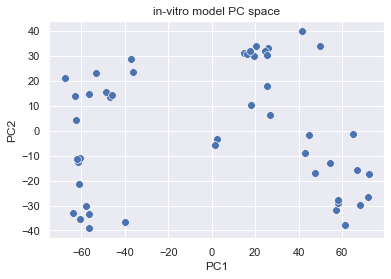

In [50]:
pca_data = pd.DataFrame(data={'PC1':Z_B[:,0], 'PC2':Z_B[:,1]})
# pca_data = pd.concat([pca_data,pd.DataFrame(data={'PC1':Z_A_B[:,0], 'PC2':Z_A_B[:,1]})])
# pca_data['dataset'] = ['in-vitro model' for i in range(Z_B.shape[0])] + ['humans' for i in range(Z_A_B.shape[0])]
# plot our PCA transformed data using sns.scatterplot() (set hue = target)
sns.scatterplot(data = pca_data , x = 'PC1',y = 'PC2', s =60 , palette= 'icefire')
plt.title('in-vitro model PC space')

In [51]:
loadings = pca.components_
print(loadings.shape)

(48, 26001)


In [52]:
Z_A_B = np.dot(X_A,loadings.T)
Z_hoang_B = np.dot(X_hoang,loadings.T)
Z_pantono_B = np.dot(X_pantono,loadings.T)
varAB = np.var(Z_A_B,axis=0).sum() + np.var(Z_hoang_B,axis=0).sum() + np.var(Z_pantono_B,axis=0).sum()
print('The explained variance of the human data in the PC-space of liver chip is {:.2f} %'.format(100*varAB/varA))

The explained variance of the human data in the PC-space of liver chip is 24.93 %


In [53]:
# varA_filt = np.var(np.dot(np.dot(X_A,Wh),Wh.T),axis=0).sum()
# Z_A_B_filt = np.dot(np.dot(np.dot(X_A,Wh),Wh.T),loadings.T)
# varAB_filt = np.var(Z_A_B_filt,axis=0).sum()
# print('The explained variance of the human data in the PC-space of liver chip is {:.2f} %'.format(100*varAB_filt/varA_filt))

In [54]:
# varA_filt = np.var(X_A-np.dot(np.dot(X_A,Wh),Wh.T),axis=0).sum()
# Z_A_B_filt = np.dot(X_A-np.dot(np.dot(X_A,Wh),Wh.T),loadings.T)
# varAB_filt = np.var(Z_A_B_filt,axis=0).sum()
# print('The explained variance of the human data in the PC-space of liver chip is {:.2f} %'.format(100*varAB_filt/varA_filt))

# Initialize perturbation as a small random dX

In [62]:
XB_lean = X_B.loc[lean_control_ind,:].values.reshape(1,X_B.shape[1])
XB_fatty = X_B.loc[fatty_control_ind,:].values.reshape(1,X_B.shape[1])
dX_lean = np.random.normal(X_B.mean(0).values,X_B.std(0).values,size=(1,XB_lean.shape[1]))
dX_lean = torch.tensor(dX_lean).float().to(device)
# dX_fatty = np.random.normal(X_B.mean(0).values,X_B.std(0).values,size=(1,XB_fatty.shape[1]))
# dX_fatty = torch.tensor(dX_fatty).float().to(device)
# Input_fatty = torch.nn.Parameter(dX_fatty, requires_grad = True)
# Input_fatty.retain_grad()
Input_lean = torch.nn.Parameter(dX_lean, requires_grad = True)
Input_lean.retain_grad()
# optimizer = torch.optim.Adam([Input_lean,Input_fatty],lr= 0.1,weight_decay=0)
optimizer = torch.optim.Adam([Input_lean],lr= 0.1,weight_decay=0)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
#                                             step_size=150,
#                                             gamma=0.8)
XB_lean = torch.tensor(XB_lean).float().to(device)
XB_lean = torch.mean(XB_lean,0,keepdim = True)
# XB_fatty = torch.tensor(XB_fatty).float().to(device)
# XB_fatty = torch.mean(XB_fatty,0,keepdim = True)
XB = torch.tensor(X_B.values).float().to(device)
XA = torch.tensor(X_A.values).float().to(device)
Xhoang = torch.tensor(X_hoang.values).float().to(device)
Xpantono = torch.tensor(X_pantono.values).float().to(device)
W_A = torch.tensor(Wh.values).float().to(device)
W_B_extra = torch.tensor(W_extra.values).float().to(device)

In [63]:
# print(XB_fatty.shape)
print(XB_lean.shape)

torch.Size([1, 26001])


Sample 0 Iteration=0, loss=-0.3193, explained_variance=32.45%
Sample 0 Iteration=200, loss=-0.4304, explained_variance=43.16%
Sample 0 Iteration=400, loss=-0.4297, explained_variance=43.20%
Sample 0 Iteration=600, loss=-0.4269, explained_variance=43.18%
Sample 0 Iteration=800, loss=-0.4286, explained_variance=43.19%
Sample 0 Iteration=999, loss=-0.4296, explained_variance=43.20%
Sample 1 Iteration=0, loss=-0.1571, explained_variance=15.94%
Sample 1 Iteration=200, loss=-0.2378, explained_variance=23.88%
Sample 1 Iteration=400, loss=-0.2373, explained_variance=23.90%
Sample 1 Iteration=600, loss=-0.2355, explained_variance=23.89%
Sample 1 Iteration=800, loss=-0.2278, explained_variance=22.90%
Sample 1 Iteration=999, loss=-0.2360, explained_variance=23.89%
Sample 2 Iteration=0, loss=-0.2428, explained_variance=24.56%
Sample 2 Iteration=200, loss=-0.3440, explained_variance=34.51%
Sample 2 Iteration=400, loss=-0.3440, explained_variance=34.55%
Sample 2 Iteration=600, loss=-0.3423, explaine

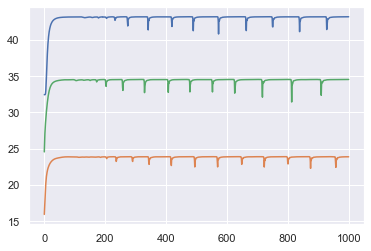

In [64]:
df_lean = pd.DataFrame({})
# #df_fatty = pd.DataFrame({})
# loss_all = []
# exp_var_all = []
iters = 1000
torch.autograd.set_detect_anomaly(True)
clinical_datasets = [XA,Xhoang,Xpantono]
# j= 0
for j in range(len(clinical_datasets)):
    Input_lean = torch.nn.Parameter(dX_lean, requires_grad = True)
    Input_lean.retain_grad()
    optimizer = torch.optim.Adam([Input_lean],lr= 0.1,weight_decay=0)
    loss_all = []
    exp_var_all = []
    for i in range(iters):
        optimizer.zero_grad()
        Xstar_lean = XB_lean + Input_lean
        #Xstar_fatty = XB_fatty + Input_fatty
        #X = torch.concat((XB,Xstar_lean,Xstar_fatty),0)
        X = torch.concat((XB,Xstar_lean),0)
        U,S,V = torch.svd(X)
        #Z_A_B = torch.matmul(XA,P.T)
        Z_A_B = torch.matmul(clinical_datasets[j],V)
        #Z_hoang_B = torch.matmul(Xhoang,V)
        #Z_pantono_B = torch.matmul(Xpantono,V)
        #varAB = torch.var(Z_A_B,axis=0).sum() +torch.var(Z_hoang_B,axis=0).sum() +torch.var(Z_pantono_B,axis=0).sum()
        varAB = torch.var(Z_A_B,axis=0).sum()

        ## spearman loss
        #lean_spear = torch.abs(spearman_corr(Input_lean.squeeze(),W_B_extra[:,0]))
        #lean_spear = lean_spear + torch.abs(spearman_corr(Input_lean.squeeze(),W_B_extra[:,1]))
        #fatty_spear = spearman_corr(Input_fatty.squeeze(),W_B_extra[:,0]) + spearman_corr(Input_fatty.squeeze(),W_B_extra[:,1])

        loss = - varAB/torch.var(clinical_datasets[j],axis=0).sum()
        loss = loss + 1e-6 * torch.sum(torch.abs(Input_lean))

        loss.backward()
        optimizer.step()
        #scheduler.step()

        exp_var = 100 * varAB/torch.var(clinical_datasets[j],axis=0).sum()
        exp_var = exp_var.item()
        loss_all.append(loss.item())
        exp_var_all.append(exp_var)
        if i % 200 == 0 :
            outString = 'Sample {:.0f} Iteration={:.0f}'.format(j,i)
            outString += ', loss={:.4f}'.format(loss.item())
            outString += ', explained_variance={:.2f}%'.format(exp_var)
            print(outString)
    outString = 'Sample {:.0f} Iteration={:.0f}'.format(j,i)
    outString += ', loss={:.4f}'.format(loss.item())
    outString += ', explained_variance={:.2f}%'.format(exp_var)
    print(outString)
    lean_dx = pd.DataFrame(Input_lean.detach().cpu().numpy())
    lean_dx.columns = X_B.columns.values
    df_lean = df_lean.append(lean_dx)
    # fatty_dx = pd.DataFrame(Input_fatty.detach().cpu().numpy())
    # fatty_dx.columns = X_B.columns.values
    # df_fatty = df_fatty.append(fatty_dx)
    plt.plot(range(iters),exp_var_all)

In [65]:
# #df_fatty.index = [i for i in range(XB_fatty.shape[0])]
# df_lean.index = [i for i in range(XB_lean.shape[0])]

In [66]:
df_lean.index = ['Govaere','Hoang','pantono']

In [67]:
df_lean

,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,GCLC,NFYA,...,DDX51,YBX2,NANOS3,ISLR,CHEK2P5,TMEM95,C1R,OR4F4,PRKACA,GOLGA6L2
Govaere,-0.096382,0.009195,-0.008632,0.061838,0.030286,0.447148,0.089542,-0.120302,-0.145121,0.146927,...,0.290768,0.363804,-0.006403,0.355361,0.000000,0.004881,0.238259,-0.001555,0.122379,0.000410
Hoang,-0.062105,-0.050000,-0.134287,0.062784,-0.022076,0.238787,0.041186,-0.233083,-0.005735,0.005592,...,-0.112522,0.234123,-0.020329,-0.265315,0.000000,0.012160,0.033251,-0.005382,-0.071178,-0.004002
pantono,0.005005,0.034783,0.083468,0.061608,0.183765,-0.174059,0.074856,-0.010839,0.029503,0.026524,...,0.051178,0.073296,-0.007174,-0.023792,0.011226,0.003329,0.147142,0.003620,0.068342,0.009000


In [68]:
# df_fatty

In [69]:
df_lean.to_csv('../results/optimized_mps/dx_lean_all_kostrzewski.csv')
# df_fatty.to_csv('../results/optimized_mps/dx_fatty_govaere_kostrzewski.csv')

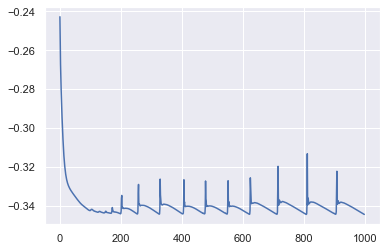

In [70]:
plt.plot(range(iters),loss_all)

In [21]:
# plt.plot(range(iters),exp_var_all)

(array([1.25826075e-04, 7.54956449e-04, 2.01321720e-03, 4.02643440e-03,
        8.68199917e-03, 3.76219964e-02, 2.50268063e-01, 1.05593242e+00,
        1.74382357e+00, 1.01415816e-01, 3.34697359e-02, 1.63573897e-02,
        6.92043412e-03, 4.65556477e-03, 2.13904327e-03, 2.13904327e-03,
        5.03304300e-04, 3.77478225e-04, 1.25826075e-04, 2.51652150e-04]),
 array([-2.454527  , -2.1488664 , -1.8432059 , -1.5375454 , -1.231885  ,
        -0.92622447, -0.620564  , -0.3149035 , -0.00924301,  0.29641747,
         0.60207796,  0.90773845,  1.2133989 ,  1.5190594 ,  1.8247199 ,
         2.1303804 ,  2.4360409 ,  2.7417014 ,  3.0473619 ,  3.3530223 ,
         3.6586828 ], dtype=float32),
 <BarContainer object of 20 artists>)

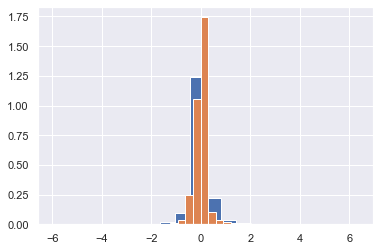

In [71]:
plt.hist(XB.detach().cpu().numpy().flatten(),20,density=True)
# plt.hist(Xstar_fatty.detach().cpu().numpy().flatten(),20,density=True)
plt.hist(Xstar_lean.detach().cpu().numpy().flatten(),20,density=True)

(array([1.37139877e-03, 4.79989569e-03, 2.05709815e-03, 4.11419631e-03,
        1.43996871e-02, 1.91995828e-02, 5.82844477e-02, 2.37937687e-01,
        9.68893231e-01, 3.45523920e+00, 9.71087469e+00, 2.49663146e+00,
        6.76785293e-01, 1.22740190e-01, 3.56563680e-02, 1.43996871e-02,
        3.42849692e-03, 1.37139877e-03, 0.00000000e+00, 6.85699385e-04]),
 array([-0.5674472 , -0.5113584 , -0.45526958, -0.39918077, -0.34309196,
        -0.28700316, -0.23091435, -0.17482555, -0.11873674, -0.06264794,
        -0.00655913,  0.04952967,  0.10561848,  0.16170728,  0.21779609,
         0.2738849 ,  0.3299737 ,  0.3860625 ,  0.4421513 ,  0.4982401 ,
         0.5543289 ], dtype=float32),
 <BarContainer object of 20 artists>)

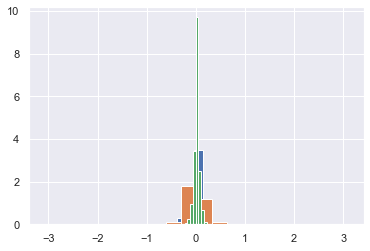

In [74]:
plt.hist(df_lean.values[0,:].flatten(),20,density=True)
plt.hist(df_lean.values[1,:].flatten(),20,density=True)
plt.hist(df_lean.values[2,:].flatten(),20,density=True)

In [24]:
# plt.hist(df_fatty.values.flatten(),20,density=True)